## 0) Imports and functions

In [167]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
from typing import Dict, Iterable, Optional, Tuple
import plotly.graph_objects as go
import numpy as np
from datetime import datetime
import os

BASE_URL = "https://api.fiscaldata.treasury.gov/services/api/fiscal_service"

def _join_filters(filters: Dict[str, Tuple[str, str]]) -> str:
    
    if not filters:
        return ""
    parts = []
    for field, (op, value) in filters.items():
        if isinstance(value, (list, tuple, set)):
            v = "(" + ",".join(map(str, value)) + ")"
        else:
            v = str(value)
        parts.append(f"{field}:{op}:{v}")
    return ",".join(parts)

def fetch_fiscaldata(
    endpoint: str,
    fields: Optional[Iterable[str]] = None,
    filters: Optional[Dict[str, Tuple[str, str]]] = None,
    sort: Optional[Iterable[str]] = None,
    page_size: int = 10000,
    max_pages: int = 200,
) -> pd.DataFrame:
    
    if not endpoint.startswith("/"):
        endpoint = "/" + endpoint
    params = []
    if fields:
        params.append("fields=" + ",".join(fields))
    if filters:
        params.append("filter=" + _join_filters(filters))
    if sort:
        params.append("sort=" + ",".join(sort))
    params.append("format=json")

    dfs = []
    for page in range(1, max_pages + 1):
        url = f"{BASE_URL}{endpoint}?{'&'.join(params)}&page[number]={page}&page[size]={page_size}"
        r = requests.get(url, timeout=60)
        r.raise_for_status()
        payload = r.json()
        data = payload.get("data", [])
        if not data:
            break
        dfs.append(pd.DataFrame(data))
        links = payload.get("links", {})
        if not links or not links.get("next"):
            break
    if not dfs:
        return pd.DataFrame()
    out = pd.concat(dfs, ignore_index=True)
    out = out.replace("null", pd.NA)
    return out

def plot_cumulative_by_year(
    df: pd.DataFrame,
    date_col: str,
    value_col: str,
    *,
    fy_start_month: int = 10,        # 1 = calendar year, 10 = U.S. fiscal year (Oct–Sep)
    years: list[int] | None = None,  # e.g., [2021, 2022, 2023, 2024, 2025]
    scale: float = 1.0,              # e.g., 1/1000 to show billions when MTS is in millions
    title: str = "Cumulative by Year",
    ylabel: str = "USD (same units as input)"
):
    """
    Plot cumulative YTD values with one line per year (calendar or fiscal).
    Designed for monthly series like MTS outlays, but works with any frequency:
    - We aggregate to month-start ('MS') to standardize and then compute cumulative by year.

    Returns: (fig, pivot) where pivot has rows = fiscal month (1..12), cols = years.
    """
    # 1) Clean + monthly aggregate (month start)
    g = df[[date_col, value_col]].copy()
    g[date_col] = pd.to_datetime(g[date_col])
    g[value_col] = pd.to_numeric(g[value_col], errors="coerce")
    g = g.dropna().sort_values(date_col).set_index(date_col)

    monthly = g[value_col].resample("MS").sum().to_frame("value")
    if monthly.empty:
        raise ValueError("No data after monthly aggregation.")

    # 2) Fiscal (or calendar) year labeling + month-in-year (1..12)
    idx = monthly.index
    if fy_start_month == 1:
        fy = idx.year
        m_in_fy = idx.month                   # 1..12
    else:
        shift = (idx.month >= fy_start_month).astype(int)
        fy = idx.year + shift
        m_in_fy = ((idx.month - fy_start_month) % 12) + 1  # 1..12 relative to FY start

    monthly = monthly.assign(fy=fy, m_in_fy=m_in_fy)

    # 3) Optional year filter
    if years is not None:
        monthly = monthly[monthly["fy"].isin(years)]
        if monthly.empty:
            raise ValueError("No rows left after filtering to requested years.")

    # 4) Cumulative within each year (+ optional scaling)
    monthly["value"] = monthly["value"] * scale
    monthly["cumu"]  = monthly.groupby("fy")["value"].cumsum()

    # 5) Pivot to month x year
    pivot = monthly.pivot(index="m_in_fy", columns="fy", values="cumu").sort_index()
    # Ensure we show months 1..12 even if early years end mid-year
    pivot = pivot.reindex(range(1, 13))

    # 6) Plotly chart
    fig = go.Figure()
    for y in pivot.columns:
        fig.add_trace(go.Scatter(
            x=pivot.index, y=pivot[y], mode="lines+markers", name=str(y)
        ))

    xlab = "Month (1=start of year)" if fy_start_month == 1 else f"Fiscal Month (1=Month {fy_start_month})"
    fig.update_layout(
        title=title,
        xaxis_title=xlab,
        yaxis_title=ylabel,
        legend_title="Year",
        template="plotly_white",
        hovermode="x unified"
    )
    return fig, pivot


def fetch_fred_quarterly_nominal_gdp(api_key: str, observation_start: str = "1980-01-01") -> pd.DataFrame:
    """
    Fetch FRED series 'GDP' (Nominal GDP, SAAR, billions), quarterly.
    Returns DataFrame with columns:
      - date (quarter end as Timestamp)
      - saar_bil (float): nominal GDP SAAR, billions
      - q_level_bil (float): quarterly nominal GDP level, billions (= SAAR / 4)
      - t4q_bil (float): trailing-4-quarter nominal GDP level, billions
      - t4q_millions (float): trailing-4-quarter nominal GDP level, millions
    """
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {
        "series_id": "GDP",
        "api_key": api_key,
        "file_type": "json",
        "frequency": "q",
        "observation_start": observation_start,
    }
    r = requests.get(url, params=params, timeout=60)
    r.raise_for_status()
    obs = r.json()["observations"]

    q = (pd.DataFrame(obs)[["date", "value"]]
         .assign(saar_bil=lambda d: pd.to_numeric(d["value"], errors="coerce"))
         .drop(columns="value")
         .dropna())
    q["date"] = pd.to_datetime(q["date"])
    q = q.sort_values("date").reset_index(drop=True)

    # Convert SAAR (annualized rate, billions) to quarterly level (billions)
    q["q_level_bil"] = q["saar_bil"] / 4.0

    # Trailing-4-quarter level (billions) → then to millions for MTS compatibility
    q["t4q_bil"] = q["q_level_bil"].rolling(4, min_periods=4).sum()
    q["t4q_millions"] = q["t4q_bil"] * 1000.0

    return q[["date", "saar_bil", "q_level_bil", "t4q_bil", "t4q_millions"]]

def build_fy_gdp_denominators_from_t4q(
    t4q_df: pd.DataFrame,
    fy_years: list[int] | None = None
) -> dict[int, float]:
    """
    From a DataFrame with columns ['date','t4q_millions'] (quarterly points),
    return a dict {FY: GDP_in_millions}, where for each fiscal year FY:
      denominator = last available T4Q value strictly before FY start (Oct 1 of prior calendar year).
    Example: FY2025 uses the last T4Q with date < 2024-10-01.
    """
    g = t4q_df.dropna(subset=["t4q_millions"]).copy().sort_values("date")
    if fy_years is None:
        # Infer a reasonable range from the data: start at first full T4Q+1, end at last full FY we can cover
        first_year = (g["date"].min().year + 1)  # rough lower bound
        last_year = g["date"].max().year + 1
        fy_years = list(range(first_year, last_year + 1))

    result = {}
    for fy in fy_years:
        fy_start = pd.Timestamp(f"{fy-1}-10-01")
        # filter to quarters strictly before FY start
        g_sub = g[g["date"] < fy_start]
        if g_sub.empty:
            continue
        denom = g_sub.iloc[-1]["t4q_millions"]
        result[fy] = float(denom)*1_000_000
    return result

def get_fy_gdp_denominators_from_fred(api_key: str, fy_years: list[int] | None = None) -> dict[int, float]:
    """
    Fetches FRED quarterly nominal GDP, builds T4Q, and returns {FY: GDP_millions} fixed denominators.
    """
    q = fetch_fred_quarterly_nominal_gdp(api_key)
    fy_denoms = build_fy_gdp_denominators_from_t4q(q, fy_years=fy_years)
    return fy_denoms

def plot_cumulative_by_fy_pct_gdp_fixed(
    df: pd.DataFrame,
    date_col: str,
    value_col: str,
    *,
    fy_denoms_millions: dict[int, float],  # {FY: GDP_millions}, fixed per FY
    years: list[int] | None = None,
    title: str = "Cumulative by Fiscal Year (% of GDP, fixed denominator)",
    ylabel: str = "% of GDP"
):
    """
    Cumulative monthly flows (e.g., Benefit Payments) normalized by a fixed nominal GDP per FY.
    """
    g = df[[date_col, value_col]].copy()
    g[date_col] = pd.to_datetime(g[date_col])
    g[value_col] = pd.to_numeric(g[value_col], errors="coerce")
    g = g.dropna().sort_values(date_col).set_index(date_col)

    # Aggregate to monthly totals (MTS is monthly already, but this standardizes)
    monthly = g[value_col].resample("MS").sum().to_frame("value")
    idx = monthly.index

    # Fiscal year label & month within fiscal year
    shift = (idx.month >= 10).astype(int)  # FY starts in October
    fy_label = idx.year + shift
    m_in_fy = ((idx.month - 10) % 12) + 1

    monthly["fy"] = fy_label
    monthly["m"]  = m_in_fy

    if years is not None:
        monthly = monthly[monthly["fy"].isin(years)]
        if monthly.empty:
            raise ValueError("No data after filtering to the requested FYs.")

    # Cumulative within FY
    monthly["cumu"] = monthly.groupby("fy")["value"].cumsum()

    # Normalize by FIXED FY denominators (millions) → % of GDP
    monthly["pct_gdp"] = monthly.apply(
        lambda r: 100.0 * r["cumu"] / fy_denoms_millions.get(int(r["fy"]), np.nan),
        axis=1
    )

    # Pivot to 1..12 fiscal months × FY columns
    pivot = monthly.pivot(index="m", columns="fy", values="pct_gdp").sort_index()
    pivot = pivot.reindex(range(1, 13))

    # Plot
    fig = go.Figure()
    for fy in pivot.columns:
        fig.add_trace(go.Scatter(x=pivot.index, y=pivot[fy], mode="lines+markers", name=str(fy)))

    fig.update_layout(
        title=title,
        xaxis_title="Fiscal Month (1=Oct)",
        yaxis_title=ylabel,
        legend_title="Fiscal Year",
        template="plotly_white",
        hovermode="x unified"
    )
    return fig, pivot

import plotly.graph_objects as go

def plot_stacked_plotly(
    pivot,
    title: str = "Stacked Time Series",
    y_label: str = "USD millions",
    scale: float = 1.0,       # e.g. 1/1000 to show billions if your data are in millions
    show_rangeslider: bool = True
):
    """
    Plot a stacked area chart from a pivoted DataFrame (index=dates, columns=categories).
    Equivalent to matplotlib's stackplot, but in Plotly.
    """
    df = pivot.sort_index().copy() * scale

    fig = go.Figure()

    # first trace drawn is the bottom of the stack
    for col in df.columns:
        fig.add_trace(go.Scatter(
            x=df.index,
            y=df[col],
            mode="lines",
            name=str(col),
            stackgroup="one",
            hovertemplate=f"%{{x|%Y-%m}}<br>{col}: %{{y:,.2f}}<extra></extra>"
        ))

    fig.update_layout(
        title=title,
        xaxis_title="Date",
        yaxis_title=y_label,
        template="plotly_white",
        hovermode="x unified",
        legend_title="Category"
    )

    if show_rangeslider:
        fig.update_xaxes(rangeslider=dict(visible=True))

    return fig


In [ ]:

FRED_API_KEY = os.getenv("FRED_API_KEY")

if FRED_API_KEY is None:
    raise RuntimeError("Missing FRED_API_KEY environment variable")

fy_denoms = get_fy_gdp_denominators_from_fred(FRED_API_KEY, fy_years=range(2015, 2026))

None


RuntimeError: Missing FRED_API_KEY environment variable

In [112]:
from datetime import date
START = "2015-01-01"    # change as needed
END = date.today().isoformat()
START, END

('2015-01-01', '2025-08-17')

In [113]:
def _finish_timeplot(ax, title: str, ylabel: str):
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Date")
    ax.grid(True, alpha=0.35)
    plt.tight_layout()

## A) Debt to the Penny

In [43]:
def get_debt_to_penny(start_date: str, end_date: str):
    df = fetch_fiscaldata(
        "v2/accounting/od/debt_to_penny",
        fields=["record_date", "debt_held_public_amt", "intragov_hold_amt", "tot_pub_debt_out_amt"],
        filters={"record_date": ("gte", start_date)},
        sort=["record_date"],
    )
    if df.empty:
        return df
    df["record_date"] = pd.to_datetime(df["record_date"])
    for col in ["debt_held_public_amt", "intragov_hold_amt", "tot_pub_debt_out_amt"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    return df[df["record_date"] <= pd.to_datetime(end_date)]

debt = get_debt_to_penny(START, END)
debt.tail()

,record_date,debt_held_public_amt,intragov_hold_amt,tot_pub_debt_out_amt
2662,2025-08-08,2.964297e+13,7.355518e+12,3.699849e+13
2663,2025-08-11,2.964353e+13,7.361283e+12,3.700482e+13
2664,2025-08-12,2.969869e+13,7.371728e+12,3.707042e+13
2665,2025-08-13,2.969849e+13,7.346845e+12,3.704534e+13
2666,2025-08-14,2.974115e+13,7.348280e+12,3.708943e+13


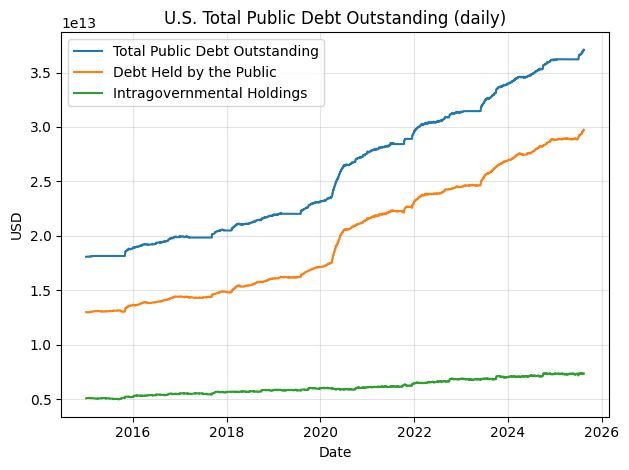

In [44]:
fig, ax = plt.subplots()
ax.plot(debt["record_date"], debt["tot_pub_debt_out_amt"], label="Total Public Debt Outstanding")
ax.plot(debt["record_date"], debt["debt_held_public_amt"], label="Debt Held by the Public")
ax.plot(debt["record_date"], debt["intragov_hold_amt"], label="Intragovernmental Holdings")
ax.legend()
_finish_timeplot(ax, "U.S. Total Public Debt Outstanding (daily)", "USD")

## B) Monthly deficit/surplus (MTS Table 1)

In [45]:
def get_mts_summary(start_date: str, end_date: str):
    df = fetch_fiscaldata(
        "v1/accounting/mts/mts_table_1",
        fields=[
            "record_date",
            "classification_desc",
            "current_month_gross_rcpt_amt",
            "current_month_gross_outly_amt",   
        ],
        filters={"record_date": ("gte", start_date)},
        sort=["record_date"],
    )
    if df.empty:
        return df
    df["record_date"] = pd.to_datetime(df["record_date"])
    for col in ["current_month_gross_rcpt_amt", "current_month_gross_outly_amt"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    monthly = (df
        .groupby("record_date", as_index=False)[
            ["current_month_gross_rcpt_amt", "current_month_gross_outly_amt"]
        ]
        .sum()
        .sort_values("record_date")
    )
    monthly = monthly[monthly["record_date"] <= pd.to_datetime(end_date)]
    monthly["current_month_deficit_amt"] = (
        monthly["current_month_gross_outly_amt"] - monthly["current_month_gross_rcpt_amt"]
    )
    return monthly

mts = get_mts_summary(START, END)
mts.tail()

,record_date,current_month_gross_rcpt_amt,current_month_gross_outly_amt,current_month_deficit_amt
120,2025-03-31,1.435679e+13,2.063584e+13,6.279043e+12
121,2025-04-30,1.605716e+13,2.181941e+13,5.762254e+12
122,2025-05-31,1.679961e+13,2.319387e+13,6.394256e+12
123,2025-06-30,1.785250e+13,2.419204e+13,6.339532e+12
124,2025-07-31,1.852949e+13,2.545130e+13,6.921818e+12


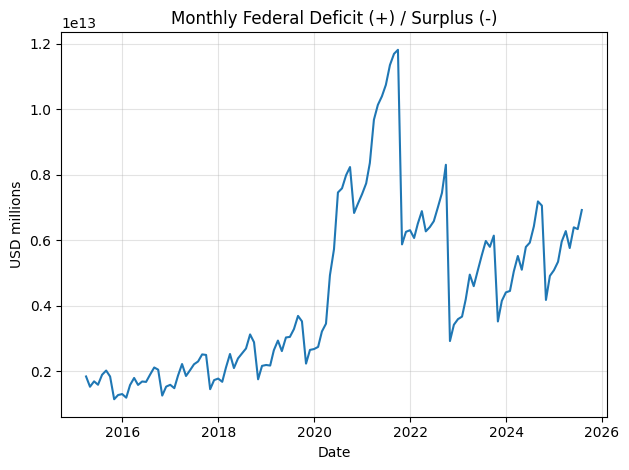

In [46]:
fig, ax = plt.subplots()
ax.plot(mts["record_date"], mts["current_month_deficit_amt"])
_finish_timeplot(ax, "Monthly Federal Deficit (+) / Surplus (-)", "USD millions")

## C1) Receipts breakdown by category (MTS Table 4)

In [114]:
def get_receipts_breakdown(start_date: str, end_date: str, top_n: int = 6):
    # Table 4 = Receipts of the U.S. Government
    df = fetch_fiscaldata(
        "v1/accounting/mts/mts_table_4",
        fields=["record_date", "classification_desc", "current_month_gross_rcpt_amt"],
        filters={"record_date": ("gte", start_date)},
        sort=["record_date"],
    )
    if df.empty:
        return df, []

    # tidy types + window
    df["record_date"] = pd.to_datetime(df["record_date"])
    df["current_month_gross_rcpt_amt"] = pd.to_numeric(df["current_month_gross_rcpt_amt"], errors="coerce")
    df = df[df["record_date"] <= pd.to_datetime(end_date)]

    # drop total rows so they don't swamp categories
    mask_total = df["classification_desc"].str.contains("^Total", na=False)
    monthly_cat = (
        df.loc[~mask_total]
          .groupby(["record_date", "classification_desc"], as_index=False)["current_month_gross_rcpt_amt"]
          .sum()
          .rename(columns={"current_month_gross_rcpt_amt": "value"})
    )

    # keep top N categories overall
    totals = monthly_cat.groupby("classification_desc")["value"].sum().sort_values(ascending=False)
    keep = totals.head(top_n).index.tolist()

    # bucket everything else into "All Other"
    bucket_label = "All Other"
    monthly_cat["category"] = monthly_cat["classification_desc"].where(
        monthly_cat["classification_desc"].isin(keep), other=bucket_label
    )

    monthly_cat = (
        monthly_cat.groupby(["record_date", "category"], as_index=False)["value"]
                   .sum()
                   .sort_values(["record_date", "category"])
    )

    pivot = monthly_cat.pivot(index="record_date", columns="category", values="value").fillna(0.0)

    # Order columns: largest total at the bottom of the stack
    col_totals = pivot.sum(axis=0).sort_values(ascending=False)
    pivot = pivot[col_totals.index]

    return pivot, list(col_totals.index)

receipts_pivot, kept = get_receipts_breakdown(START, END, top_n=8)
receipts_pivot.tail()

category,Withheld,Federal Insurance Contributions Act Taxes,Other,Corporation Income Taxes,All Other,Customs Duties,Self-Employment Contributions Act Taxes,"Deposit of Earnings, Federal Reserve System",Deposits by States
record_date,,,,,,,,,
2025-03-31,2.227041e+11,1.412520e+11,3.244229e+10,2.030422e+10,1.232794e+10,8.748882e+09,2.746000e+09,5.349936e+08,2.718569e+08
2025-04-30,1.702135e+11,1.353580e+11,4.532109e+11,9.686599e+10,2.512851e+10,1.630303e+10,3.669700e+10,6.033402e+08,6.928450e+09
2025-05-31,1.158599e+11,1.313760e+11,4.938207e+10,4.602122e+10,1.717730e+10,2.282106e+10,1.765000e+09,4.375019e+08,1.352618e+10
2025-06-30,1.275034e+11,1.438490e+11,1.216980e+11,7.057080e+10,3.188952e+10,2.715458e+10,1.374900e+10,4.613234e+08,6.390888e+09
2025-07-31,1.397223e+11,1.239070e+11,1.882372e+10,2.537254e+10,1.579259e+10,2.844033e+10,1.349000e+09,4.736200e+08,3.740524e+09


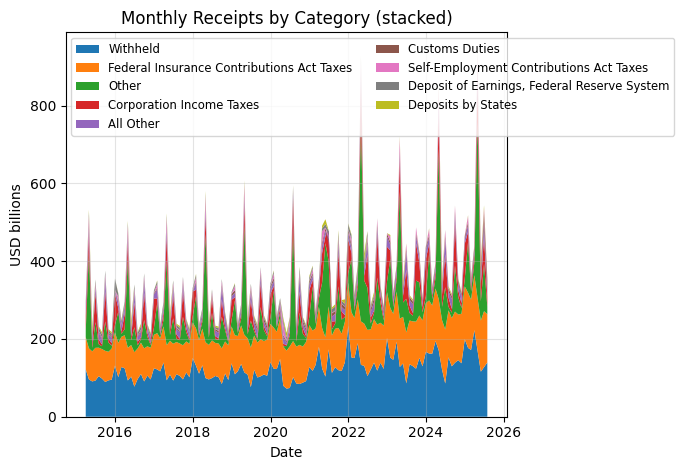

In [125]:
fig, ax = plt.subplots()
receipts_pivot = receipts_pivot.sort_index()
ax.stackplot(receipts_pivot.index, receipts_pivot.values.T / 1e9, labels=receipts_pivot.columns.tolist())
ax.legend(loc="upper left", ncols=2, fontsize="small")
_finish_timeplot(ax, "Monthly Receipts by Category (stacked)", "USD billions")

In [133]:
fig = plot_stacked_plotly(
    receipts_pivot,
    title="Monthly Receipts by Category (stacked)",
    y_label="USD",
    scale=1   # convert millions → billions
)
fig.show()

In [134]:
# Build a tidy frame for one category
focus = receipts_pivot["Customs Duties"].reset_index()
focus.columns = ["record_date", "value"]  # rename for convenience

# Plot as *fiscal-year* cumulative (MTS default is fiscal framing)
fig, pivot = plot_cumulative_by_year(
    focus,
    date_col="record_date",
    value_col="value",
    fy_start_month=10,          # fiscal years (Oct–Sep)
    years=None,                 # or [2021, 2022, 2023, 2024, 2025]
    scale=1,               # MTS is in millions → show billions
    title="Custom Duties — Cumulative by Fiscal Year",
    ylabel="USD"
)
fig.show()

In [120]:
# 2) Prepare Customs Duties series (millions)
# If you already have `outlays_pivot` from get_outlays_breakdown(...):
focus = receipts_pivot["Customs Duties"].reset_index()
focus.columns = ["record_date", "value"]

# 3) Plot cumulative FY as % of GDP (fixed denominators)
fig, pivot = plot_cumulative_by_fy_pct_gdp_fixed(
    focus,
    date_col="record_date",
    value_col="value",
    fy_denoms_millions=fy_denoms,
    years=None,
    title="Customs Duties — Cumulative % of GDP (Fixed FY Denominator)"
)
fig.show()

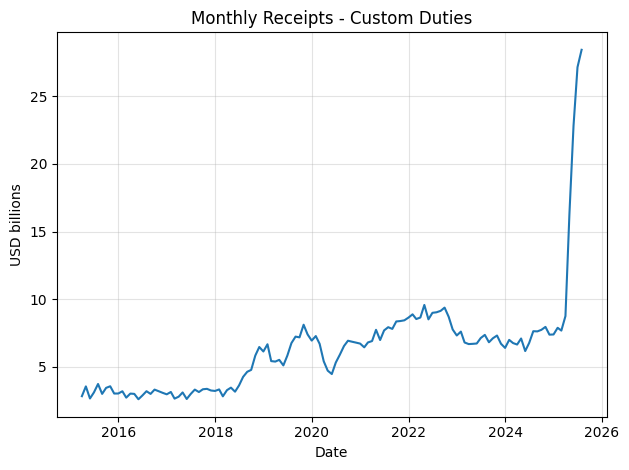

In [135]:
fig, ax = plt.subplots()
ax.plot(receipts_pivot["Customs Duties"]/ 1e9)
_finish_timeplot(ax, "Monthly Receipts - Custom Duties", "USD billions")

## C2) Payments breakdown by category

In [90]:
def get_outlays_breakdown(start_date: str, end_date: str, top_n: int = 6):
    df = fetch_fiscaldata(
        "v1/accounting/mts/mts_table_5",
        fields=["record_date", "classification_desc", "current_month_gross_outly_amt"],
        filters={"record_date": ("gte", start_date)},
        sort=["record_date"],
    )
    if df.empty:
        return df, []

    # types + window
    df["record_date"] = pd.to_datetime(df["record_date"])
    df["current_month_gross_outly_amt"] = pd.to_numeric(df["current_month_gross_outly_amt"], errors="coerce")
    df = df[df["record_date"] <= pd.to_datetime(end_date)]

    # drop totals
    df = df[~df["classification_desc"].str.contains(r"^Total", na=False)].copy()

    # monthly by classification
    monthly_cat = (df.groupby(["record_date", "classification_desc"], as_index=False)["current_month_gross_outly_amt"]
                     .sum()
                     .rename(columns={"current_month_gross_outly_amt": "value"}))

    # pick top-N categories by total over the window
    totals = monthly_cat.groupby("classification_desc")["value"].sum().sort_values(ascending=False)
    keep = totals.head(top_n).index.tolist()

    # bucket remainder
    bucket_label = "All Other"
    monthly_cat["category"] = monthly_cat["classification_desc"].where(
        monthly_cat["classification_desc"].isin(keep), other=bucket_label
    )

    # re-aggregate with bucket, pivot
    monthly_cat = (monthly_cat.groupby(["record_date", "category"], as_index=False)["value"]
                             .sum()
                             .sort_values(["record_date", "category"]))
    pivot = monthly_cat.pivot(index="record_date", columns="category", values="value").fillna(0.0)

    # order columns by total size (largest first => drawn at bottom in stackplot)
    col_totals = pivot.sum(axis=0).sort_values(ascending=False)
    pivot = pivot[col_totals.index]

    return pivot, list(col_totals.index)

outlays_pivot, outlays_kept = get_outlays_breakdown(START, END, top_n=8)
outlays_pivot.tail()

category,Benefit Payments,All Other,Grants to States for Medicaid,Public Issues (Accrual Basis),Payments to Health Care Trust Funds,Other,Department of the Air Force,Department of the Navy,Special Issues (Cash Basis)
record_date,,,,,,,,,
2025-03-31,1.874118e+11,1.313731e+11,5.664911e+10,9.060649e+10,4.484197e+10,1.688663e+10,1.773346e+10,1.856345e+10,1.380694e+10
2025-04-30,2.292211e+11,1.323951e+11,5.811634e+10,8.461923e+10,6.476862e+10,2.129115e+10,1.945062e+10,1.882855e+10,1.703113e+10
2025-05-31,2.969973e+11,1.786601e+11,5.822922e+10,8.298627e+10,4.433152e+10,1.736500e+10,2.079531e+10,2.229824e+10,9.244133e+09
2025-06-30,1.743890e+11,5.909809e+10,5.508093e+10,8.173014e+10,5.896844e+10,1.873919e+10,1.995547e+10,1.913073e+10,6.289454e+10
2025-07-31,2.485137e+11,1.796283e+11,6.211509e+10,8.317926e+10,4.901704e+10,2.151077e+10,2.044761e+10,2.111487e+10,8.733653e+09


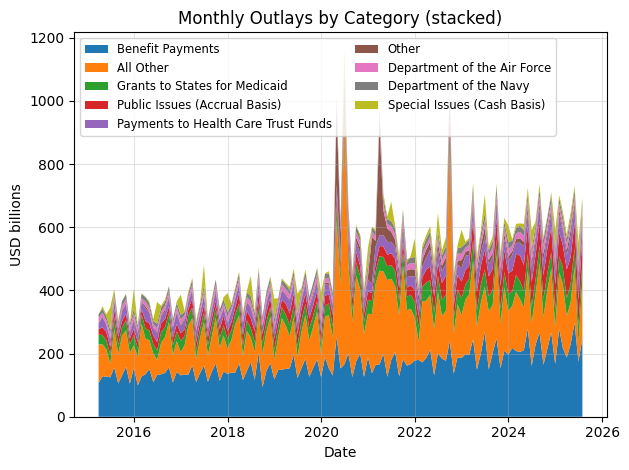

In [136]:
fig, ax = plt.subplots()
outlays_pivot = outlays_pivot.sort_index()
ax.stackplot(outlays_pivot.index, outlays_pivot.values.T / 1e9, labels=outlays_pivot.columns.tolist())
ax.legend(loc="upper left", ncols=2, fontsize="small")
_finish_timeplot(ax, "Monthly Outlays by Category (stacked)", "USD billions")

In [141]:
fig = plot_stacked_plotly(
    outlays_pivot,
    title="Monthly Payments by Category (stacked)",
    y_label="USD",
    scale=1   # 1/1000 convert millions → billions
)
fig.show()

In [137]:
# Build a tidy frame for one category
benefit = outlays_pivot["Benefit Payments"].reset_index()
benefit.columns = ["record_date", "value"]  # rename for convenience

# Plot as *fiscal-year* cumulative (MTS default is fiscal framing)
fig, pivot = plot_cumulative_by_year(
    benefit,
    date_col="record_date",
    value_col="value",
    fy_start_month=10,          # fiscal years (Oct–Sep)
    years=None,                 # or [2021, 2022, 2023, 2024, 2025]
    scale=1,               # MTS is in millions → show billions
    title="Benefit Payments — Cumulative by Fiscal Year",
    ylabel="USD"
)
fig.show()

In [126]:
# 2) Prepare Customs Duties series (millions)
# If you already have `outlays_pivot` from get_outlays_breakdown(...):
focus = outlays_pivot["Benefit Payments"].reset_index()
focus.columns = ["record_date", "value"]

# 3) Plot cumulative FY as % of GDP (fixed denominators)
fig, pivot = plot_cumulative_by_fy_pct_gdp_fixed(
    focus,
    date_col="record_date",
    value_col="value",
    fy_denoms_millions=fy_denoms,
    years=None,
    title="Benefit Payments — Cumulative % of GDP (Fixed FY Denominator)"
)
fig.show()

## D) Treasury General Account

basically the bank account of the gov at the fed

In [163]:
def get_tga_balance(start_date: str, end_date: str) -> pd.DataFrame:
    df = fetch_fiscaldata(
        "v1/accounting/dts/operating_cash_balance",
        filters={"record_date": ("gte", start_date)},
        sort=["record_date"],
    )
    if df.empty:
        return df

    df["record_date"] = pd.to_datetime(df["record_date"], errors="coerce")
    df["open_today_bal"] = pd.to_numeric(df["open_today_bal"], errors="coerce")

    # per day, take the max balance (TGA is the largest)
    daily = (
        df.dropna(subset=["open_today_bal"])
          .groupby("record_date", as_index=False)["open_today_bal"]
          .max()
          .rename(columns={"open_today_bal": "tga_balance"})
          .sort_values("record_date")
    )

    daily = daily[daily["record_date"] <= pd.to_datetime(end_date)].reset_index(drop=True)
    return daily

tga = get_tga_balance(START, END)
tga.tail()

,record_date,tga_balance
2663,2025-08-08,491691
2664,2025-08-11,504280
2665,2025-08-12,545499
2666,2025-08-13,545499
2667,2025-08-14,549080


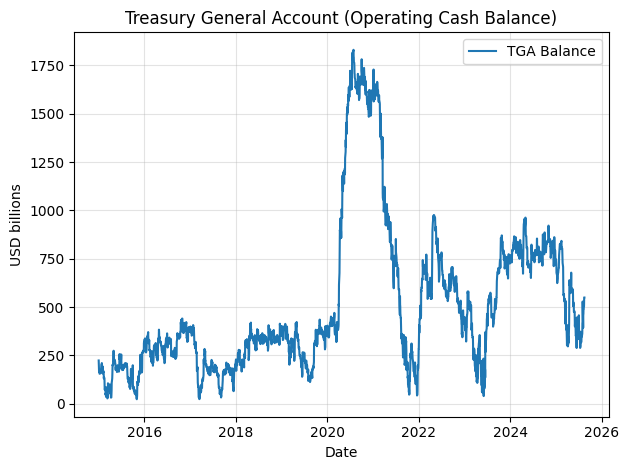

In [164]:
tga = get_tga_balance(START, END)

fig, ax = plt.subplots()
ax.plot(tga["record_date"], tga["tga_balance"]/1e3, label="TGA Balance")  # millions → billions
ax.legend()
_finish_timeplot(ax, "Treasury General Account (Operating Cash Balance)", "USD billions")

In [165]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=tga["record_date"],
    y=tga["tga_balance"] / 1e3,   # millions → billions
    mode="lines",
    name="TGA Balance",
    line=dict(color="blue", width=1.5)
))

fig.update_layout(
    title="Treasury General Account (Operating Cash Balance)",
    xaxis_title="Date",
    yaxis_title="USD billions",
    template="plotly_white",
    hovermode="x unified",
    legend_title="Series"
)

fig.show()